In [ ]:
!pip3 install librosa==0.6.3 numpy soundfile==0.9.0

  Using cached librosa-0.6.3-py3-none-any.whl
  Using cached SoundFile-0.9.0-py2.py3-none-any.whl.metadata (9.3 kB)
Using cached SoundFile-0.9.0-py2.py3-none-any.whl (24 kB)
  Attempting uninstall: soundfile
    Found existing installation: soundfile 0.13.1
    Uninstalling soundfile-0.13.1:
      Successfully uninstalled soundfile-0.13.1
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


In [ ]:
!pip install librosa
!pip install numba --upgrade


In [ ]:
!sudo apt-get update
!sudo apt-get install -y portaudio19-dev python3-pyaudio


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
!pip uninstall librosa numba
!pip install librosa numba


Found existing installation: librosa 0.6.3
Uninstalling librosa-0.6.3:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/librosa-0.6.3.dist-info/*
    /usr/local/lib/python3.11/dist-packages/librosa/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.11/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1154.py311.1.nbc
    /usr/local/lib/python3.11/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1154.py311.2.nbc
    /usr/local/lib/python3.11/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1154.py311.nbi
    /usr/local/lib/python3.11/dist-packages/librosa/core/__pycache__/guf-audio._zc_wrapper-1154.py311.1.nbc
    /usr/local/lib/python3.11/dist-packages/librosa/core/__pycache__/guf-audio._zc_wrapper-1154.py311.2.nbc
    /usr/local/lib/python3.11/dist-packages/librosa/core/__pycache__/guf-audio._zc_wrapper-1154.py311.nbi
    /usr/local/lib/python3.11/dist-packages/librosa/core/__pycache__/guf-pitch._pi_wrapper-430.py311.1.nbc
    

In [ ]:
import soundfile # to read audio file
import numpy as np
import librosa # to extract speech features
import glob
import os
import pickle # to save model after training
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score # to measure how good we are

In [ ]:
import kagglehub
import shutil
import os

# Download the dataset (defaults to ~/.cache/kagglehub/datasets)
dataset_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# Define your target path
destination_path = "/content/sample_data/"

# Ensure the destination directory exists
os.makedirs(destination_path, exist_ok=True)

# Move the dataset to the desired location
shutil.move(dataset_path, destination_path)

print("Dataset moved to:", destination_path)


100%|██████████| 429M/429M [00:07<00:00, 61.9MB/s]

Extracting files...


Dataset moved to: /content/sample_data/


In [ ]:
import librosa
import numpy as np

def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")

    # Load the audio file
    X, sample_rate = librosa.load(file_name, sr=None)

    # Check the length of the signal and adjust n_fft accordingly
    n_fft = 2048 if len(X) > 2048 else len(X)  # Use smaller n_fft if the signal is too short

    # Initialize the result as an empty list
    result = []

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result.extend(mfccs)

    if chroma:
        stft = np.abs(librosa.stft(X, n_fft=n_fft))
        chroma_feature = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result.extend(chroma_feature)

    if mel:
        mel_feature = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate, n_fft=n_fft).T, axis=0)
        result.extend(mel_feature)

    if contrast:
        stft = np.abs(librosa.stft(X, n_fft=n_fft))
        contrast_feature = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
        result.extend(contrast_feature)

    if tonnetz:
        tonnetz_feature = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
        result.extend(tonnetz_feature)

    return np.array(result)  # Return the result as a numpy array (1D array)


In [ ]:
# all emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these emotions ( feel free to tune this on your need )
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}

def load_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("/content/sample_data/data/Actor_*/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract speech features
        features = extract_feature(file, mfcc=True, chroma=True, mel=True)
        # add to data
        X.append(features)
        y.append(emotion)
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [ ]:

# load RAVDESS dataset, 70% training 30% testing
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize SVM classifier
svm_model = SVC(kernel='linear')  # You can change the kernel if needed

# Train the model
svm_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_svm = svm_model.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}")


SVM Accuracy: 0.6011904761904762


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

# Train the model
rf_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")


Random Forest Accuracy: 0.6190476190476191


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_knn = knn_model.predict(X_test)
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn)}")


KNN Accuracy: 0.5833333333333334


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize Logistic Regression classifier
logreg_model = LogisticRegression(max_iter=1000)

# Train the model
logreg_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_logreg = logreg_model.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_logreg)}")


Logistic Regression Accuracy: 0.6488095238095238


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

import os
import pickle

In [ ]:
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08,
    'hidden_layer_sizes': (300,),
    'learning_rate': 'adaptive',
    'max_iter': 500,
}
# initialize Multi Layer Perceptron classifier
# with best parameters ( so far )
model = MLPClassifier(**model_params)

# train the model
print("[*] Training the model...")
model.fit(X_train, y_train)

# predict 25% of data to measure how good we are
y_pred = model.predict(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

# now we save the model
# make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(model, open("result/mlp_classifier.model", "wb"))


[*] Training the model...
Accuracy: 71.43%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate SVM Model
print("SVM Model Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

# Evaluate Random Forest Model
print("Random Forest Model Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Evaluate KNN Model
print("KNN Model Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

# Evaluate Logistic Regression Model
print("Logistic Regression Model Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

# Evaluate MLP Model
print("MLP Model Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


SVM Model Evaluation
Confusion Matrix:
 [[32 10  1  3]
 [ 9 39  1  7]
 [ 2  3 12  9]
 [ 3 13  6 18]]
Classification Report:
               precision    recall  f1-score   support

       angry       0.70      0.70      0.70        46
       happy       0.60      0.70      0.64        56
     neutral       0.60      0.46      0.52        26
         sad       0.49      0.45      0.47        40

    accuracy                           0.60       168
   macro avg       0.60      0.58      0.58       168
weighted avg       0.60      0.60      0.60       168

Random Forest Model Evaluation
Confusion Matrix:
 [[33  8  1  4]
 [10 34  2 10]
 [ 2  2 13  9]
 [ 2 12  2 24]]
Classification Report:
               precision    recall  f1-score   support

       angry       0.70      0.72      0.71        46
       happy       0.61      0.61      0.61        56
     neutral       0.72      0.50      0.59        26
         sad       0.51      0.60      0.55        40

    accuracy                     

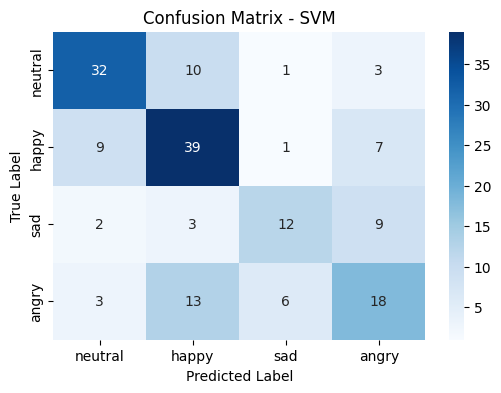

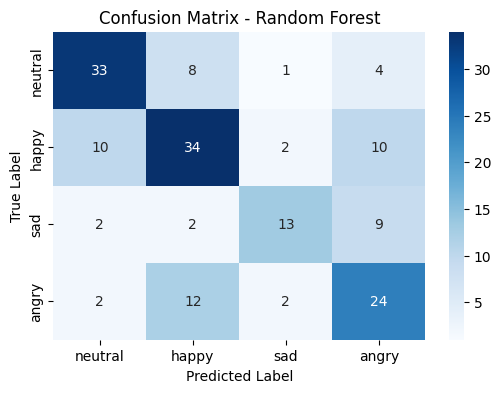

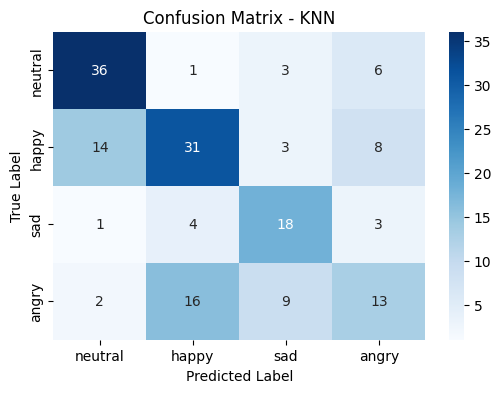

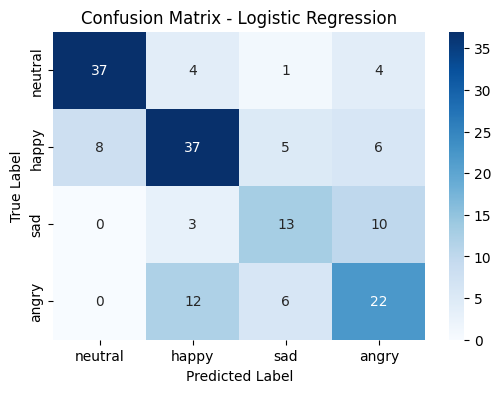

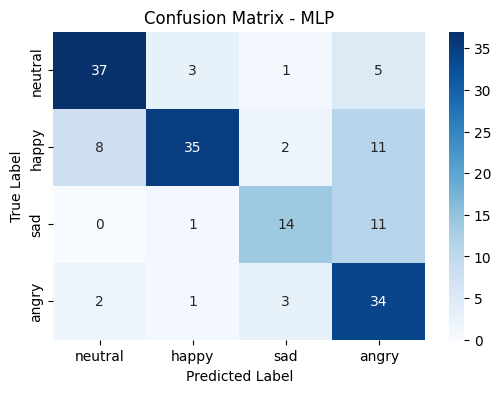

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Call the function for each model
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_knn, "KNN")
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred, "MLP")


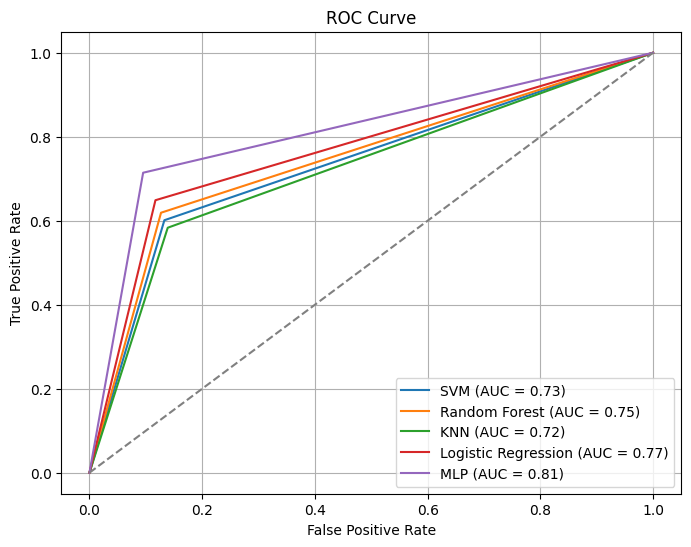

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to binary format for ROC curve (Only valid for binary classification)
y_test_bin = label_binarize(y_test, classes=list(set(y_test)))

plt.figure(figsize=(8, 6))

for model_name, y_pred in zip(
    ["SVM", "Random Forest", "KNN", "Logistic Regression", "MLP"],
    [y_pred_svm, y_pred_rf, y_pred_knn, y_pred_logreg, y_pred]
):
    y_pred_bin = label_binarize(y_pred, classes=list(set(y_test)))
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


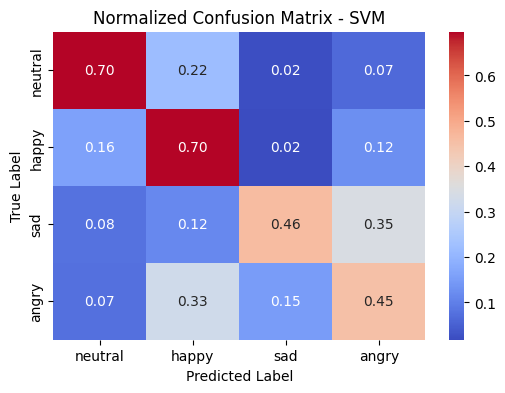

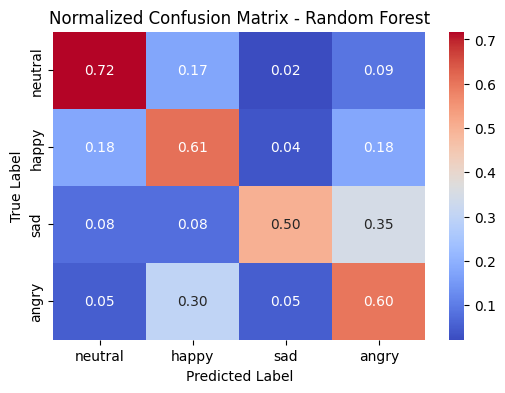

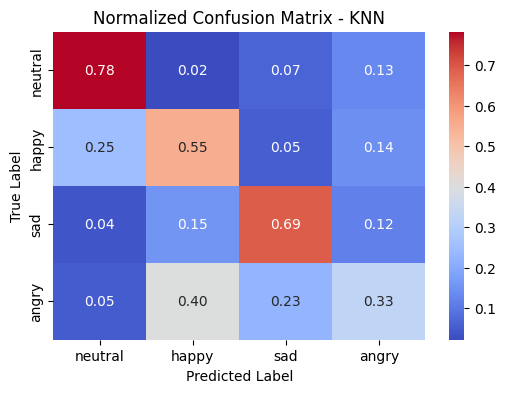

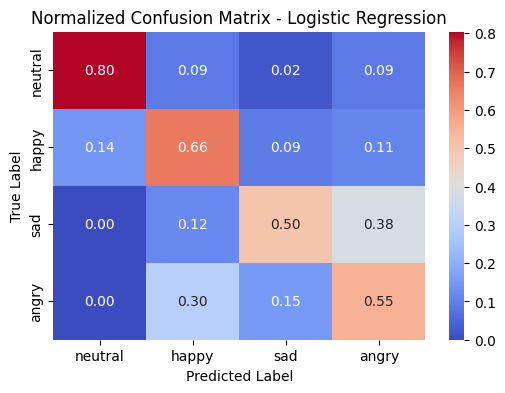

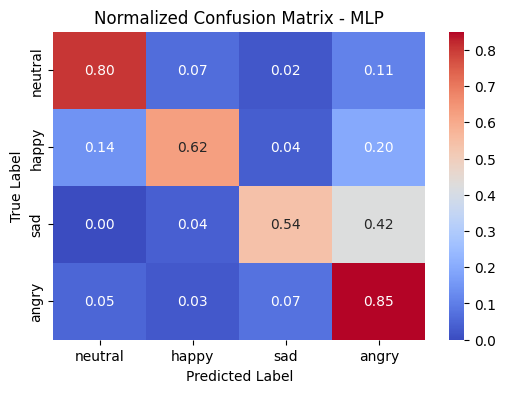

In [ ]:
def plot_normalized_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Normalized Confusion Matrix - {model_name}")
    plt.show()

# Generate for each model
plot_normalized_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_normalized_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_normalized_confusion_matrix(y_test, y_pred_knn, "KNN")
plot_normalized_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")
plot_normalized_confusion_matrix(y_test, y_pred, "MLP")


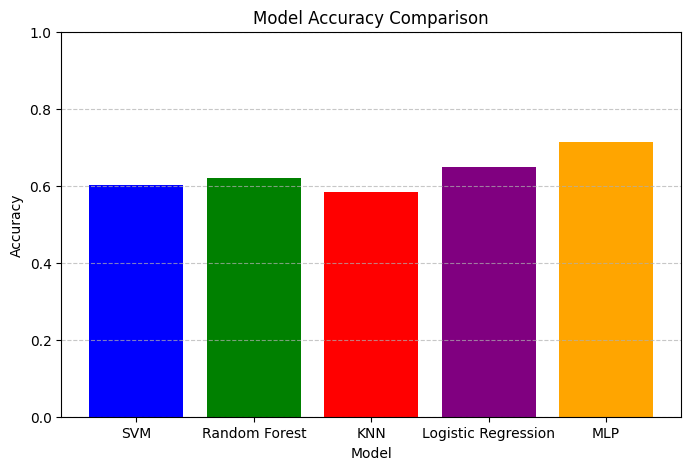

In [ ]:
accuracies = {
    "SVM": accuracy_score(y_test, y_pred_svm),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "Logistic Regression": accuracy_score(y_test, y_pred_logreg),
    "MLP": accuracy_score(y_test, y_pred),
}

plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=["blue", "green", "red", "purple", "orange"])
plt.ylim(0, 1)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


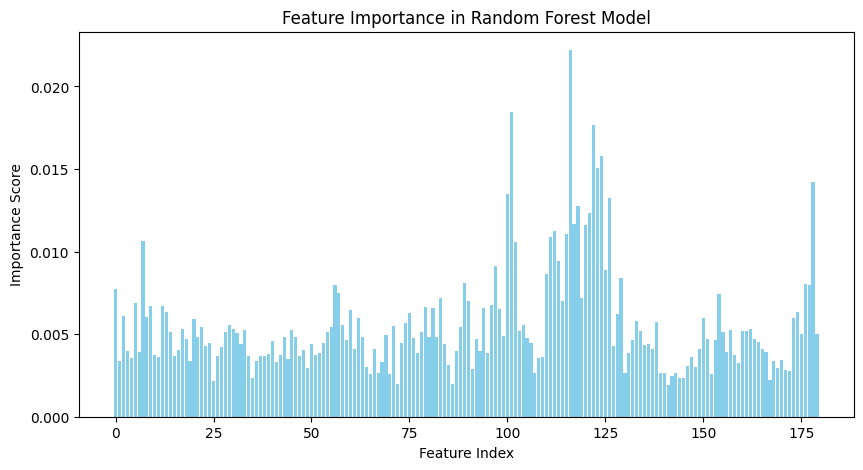

In [ ]:
feature_importance = rf_model.feature_importances_
plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importance)), feature_importance, color="skyblue")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Random Forest Model")
plt.show()
